# Inferring ages from velocity dispersions.

I want to build a hierarchical model, where I infer the velocity dispersion (root-variance) of the velocities, vz, by deconvolving the transformation between vb and vz. The variance on each velocity, vb, is artificially increased as a function of b: $\sigma = 0.44 b + 0.15$

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
np.random.seed(42)
N = 1000

beta = .52
m, c = .44, .15
b = np.random.uniform(5, 15, N)

age = 9
t = np.ones(N)*age
vz = np.random.randn(N)*(age**beta)
vb = vz + np.random.randn(N)*(m*b + c)
vb_err = np.ones(N)*(.1*vb)
vb += np.random.randn(N)*vb_err

Text(0.5, 0, 'Velocity')

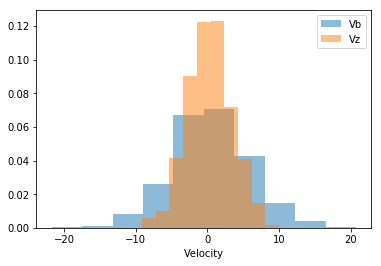

In [4]:
plt.hist(vb, density=True, alpha=.5, label="Vb");
plt.hist(vz, density=True, alpha=.5, label="Vz");
plt.legend()
plt.xlabel("Velocity")

Task: try to recover the age that was used to generate these velocities (5 Gyr).

$$\sigma_v = t^\beta$$
$$t = \sigma_v^{1/\beta}$$

In [5]:
vb_age = np.std(vb)**(1./beta)
vz_age = np.std(vz)**(1./beta)
print(vb_age, vz_age)

26.251819190907305 8.800964193982916


Build a hierarchical model, marginalizing over vz for each star, in order to infer mu and sigma of the true Gaussian.

In [6]:
import pymc3 as pm

simple_model = pm.Model()

with simple_model:
    
    # Prior over mu
    mu = pm.Uniform("mu", lower=-100, upper=100)
    # Prior over sigma
    sigma = pm.Uniform("sigma", lower=0, upper=100)
    
    # vz
    vz_hat = pm.Normal("vz_hat", mu=mu, sigma=sigma, shape=N)
    
    ivar_b, ivar_z = vb_err**(-2), (m*b + c)**(-2)
    ivar = ivar_b + ivar_z
    
    # vb (the likelihood)
    vb_hat = pm.Normal("vb_hat", mu=vz_hat, sigma=np.sqrt(1./ivar), observed=vb)
    
# simple_model = pm.Model()

# with simple_model:
    
#     # Prior over mu
#     mu = pm.Uniform("mu", lower=-100, upper=100)
#     # Prior over sigma
#     sigma = pm.Uniform("sigma", lower=0, upper=100)
    
#     # p(vb|sigma_vb, sigma_vz, vz)
#     lnprob = sum(-.5*(vb**2/(1./var)))
    
#     # vz
#     vz_hat = pm.Normal("vz_hat", mu=mu, sigma=sigma, shape=N)
    
#     ivar_b, ivar_z = vb_err**(-2), (m*b + c)**(-2)
#     ivar = ivar_b + ivar_z
#     # vb (the likelihood)
#     vb_hat = pm.Normal("vb_hat", mu=vz_hat, sigma=np.sqrt(1./ivar), observed=vb)

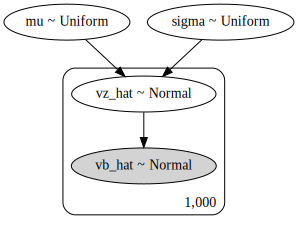

In [7]:
pm.model_to_graphviz(simple_model)

In [8]:
with simple_model:
    trace = pm.sample(tune=5000, draws=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vz_hat, sigma, mu]
Sampling 4 chains: 100%|██████████| 40000/40000 [01:06<00:00, 598.48draws/s] 


In [9]:
print(np.median(trace.mu), np.median(trace.sigma))

0.4527197434151944 5.329198075261025


In [10]:
print("age = ", np.median(trace.sigma)**(1./beta))

age =  24.970466641017566


In [15]:
ages, err, errp, errm = [], [], [], []

for age in range(1, 10):
    
    # Generate data
    print("testing age = ", age)
    t = np.ones(N)*age
    vz = np.random.randn(N)*(age**beta)
    vb = vz + np.random.randn(N)*(m*b + c)
    vb_err = np.ones(N)*(.1*vb)
    vb += np.random.randn(N)*vb_err
    
    # Hierarchical model
    simple_model = pm.Model()
    with simple_model:
        # Prior over mu
        mu = pm.Uniform("mu", lower=-100, upper=100)
        # Prior over sigma
        sigma = pm.Uniform("sigma", lower=0, upper=100)
        # vz
        vz_hat = pm.Normal("vz_hat", mu=mu, sigma=sigma, shape=N)
#         ivar_b, ivar_z = vb_err**(-2), (m*b + c)**(-2)
#         ivar = ivar_b + ivar_z
        # vb (the likelihood)
        vb_hat = pm.Normal("vb_hat", mu=vz_hat, sigma=np.sqrt(vb_err**2 + (m*b+c)**2), observed=vb)
        
    # Sample
    with simple_model:
        trace = pm.sample(tune=5000, draws=5000)
        
    age_array = trace.sigma**(1./beta)
    ages.append(np.median(age_array))
    err.append(np.std(age_array))
    upper, lower = np.percentile(age_array, 85), np.percentile(age_array, 16)
    errp.append(upper - np.median(age_array))
    errm.append(np.median(age_array) - lower)

testing age =  1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vz_hat, sigma, mu]
Sampling 4 chains: 100%|██████████| 40000/40000 [01:32<00:00, 431.26draws/s]
There were 265 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5768153038273935, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5796646738666796, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


testing age =  2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vz_hat, sigma, mu]
Sampling 4 chains: 100%|██████████| 40000/40000 [01:37<00:00, 409.23draws/s] 
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7180377837254882, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6827448046316111, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 4830 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.10514380051458613, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. Th

testing age =  3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vz_hat, sigma, mu]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:45<00:00, 877.78draws/s] 
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6467874700402405, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7082898020780815, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


testing age =  4


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vz_hat, sigma, mu]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:55<00:00, 723.19draws/s] 
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3496281640710514, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


testing age =  5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vz_hat, sigma, mu]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:36<00:00, 1084.52draws/s]
The number of effective samples is smaller than 10% for some parameters.


testing age =  6


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vz_hat, sigma, mu]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:37<00:00, 1075.49draws/s]
The number of effective samples is smaller than 10% for some parameters.


testing age =  7


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vz_hat, sigma, mu]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:39<00:00, 1016.08draws/s]
The number of effective samples is smaller than 10% for some parameters.


testing age =  8


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vz_hat, sigma, mu]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:39<00:00, 1008.75draws/s]
The number of effective samples is smaller than 10% for some parameters.


testing age =  9


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vz_hat, sigma, mu]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:43<00:00, 922.55draws/s] 
The number of effective samples is smaller than 25% for some parameters.


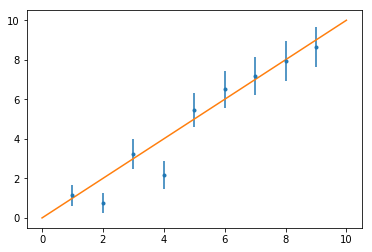

In [16]:
xs = np.linspace(0, 10, 100)
plt.errorbar(range(1, 10), ages, yerr=err, fmt=".")
plt.plot(xs, xs)

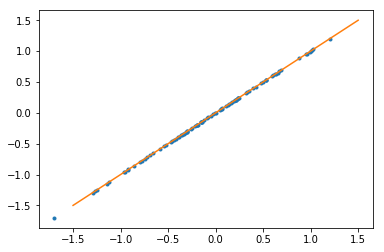

In [17]:
np.random.seed(42)
d, e = .5, 2
rand = np.random.randn(100)
w = rand*d
w += rand*c

q = rand*(d + c)
r = rand*(np.sqrt(d**2 + c**2))

plt.plot(w, q, ".")
xs1 = np.linspace(-1.5, 1.5, 100)
plt.plot(xs1, xs1)